# Clustering - Countries by Categories

#### To classify countries according to socio-economic and health indicators that determine the overall development of a country.

## Data Understanding

In [8]:
# Load important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
import os

# Clustering libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')


# Helper function with dataset download on the go!

filename = "country-data.csv"

def getDataset(filename, **kwargs):
    url = f"https://raw.githubusercontent.com/azizzoaib786/clustering-countries-dataset/main/{filename}"
    try:
        if filename not in os.listdir():
            # Install wget if not already installed
            try:
                import wget
            except ImportError:
                !pip install wget
                import wget

            # Download the file
            wget.download(url, filename)
            print(f"\n{filename} file downloaded successfully.")
        else:
            print(f"{filename} already exists.")
        return pd.read_csv(filename, **kwargs)
    except Exception as e:
        print(e)
        return pd.read_csv(url, **kwargs)

data = getDataset(filename, encoding="unicode_escape")

# Check the head of the data
data.head()


country-data.csv file downloaded successfully.


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


#### Features explanation

country: Name of the country

child_mort: Death of children under 5 years of age per 1000 live births

exports: Exports of goods and services per capita. Given as %age of the GDP per capita

health: Total health spending per capita. Given as %age of GDP per capita

imports: Imports of goods and services per capita. Given as %age of the GDP per capita

Income: Net income per person

Inflation: The measurement of the annual growth rate of the Total GDP

life_expec: The average number of years a new born child would live if the current mortality patterns are to remain the same

total_fer: The number of children that would be born to each woman if the current age-fertility rates remain the same

gdpp: The GDP per capita. Calculated as the Total GDP divided by the total population.

In [9]:
# Check the data info
data.info()

# Describe the data
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


After looking at the above data we can identify some of important points of the data above.

1. The mean values are higher than the median, which shows that distribution of the data might be positively skewed (tail on the right side).
2. Outliers are present because of the much larger values present (for eg. the max value) than the 75th percentile.

In [10]:
# Check rows and columns
data.shape

(167, 10)

In [11]:
# Check null values

data.isnull().sum()

# We can confirm that there are no null values in the data.

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [12]:
# Check the duplicates in the data
print('Duplicates:', len(data[data.duplicated()]))


Duplicates: 0


## Data Visualizations

In [13]:
# Lets check the choropleth plot on original dataset which will help to validate our final result after clustering.
columns_to_drop = ['country', 'health', 'inflation', 'life_expec', 'exports']
countries_map = list(data.drop(columns_to_drop, axis = 1)) 

for column in countries_map:
    fig = px.choropleth(data,
                       locationmode = 'country names', 
                       locations = 'country',
                       color = column, #  the choropleth map is colored based on the current column being iterated over in the loop
                       title = 'Country by ' + column,
                       color_continuous_scale = 'Greens')
    
    fig.update_layout(paper_bgcolor = 'lightgrey')
    
    fig.show()

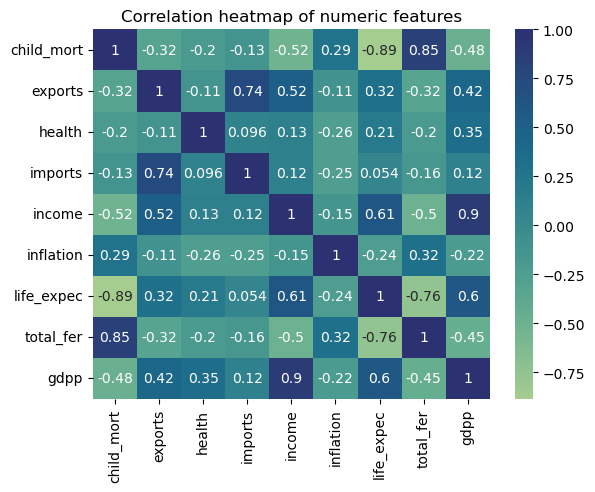

In [14]:
# Coorelation Matrix
correlation_matrix = data.drop('country', axis=1).corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'crest')

plt.title('Correlation heatmap of numeric features')
plt.show()

Based on the above Correlation Matrix:
1. We can observe that there is high positive coorelation between **total_fert** & **child_mort** and also between **imports & exports, income & exports, gdpp, life_expec & income**.
2. We can also observe slight positive correlation between the **income** and the **child_mort**.

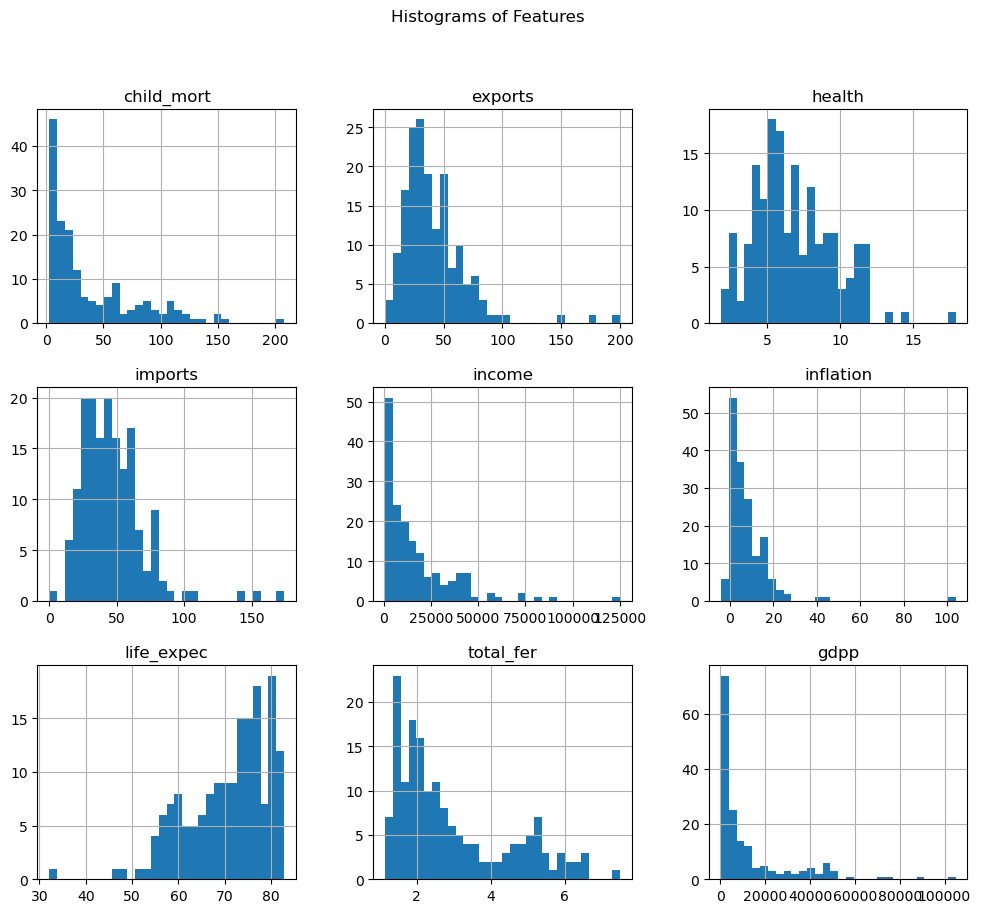

In [15]:
# Plot histograms for each feature
data.drop('country', axis=1).hist(bins=30, figsize=(12, 10))
plt.suptitle('Histograms of Features')
plt.show()

Based on the above Histogram:

1. Based on the plots we can observe that it has come outliers, but expected due to critical condditions of some countries (we will not consider them as noise).
2. We can also notice that data is distributed with low and high values for example: income vs health.

## Data Scaling

### We will use Normalization method for PCA, based on above distribution results

#### We will use MinMax Scaler technique

In [16]:
mixmax_scaler = MinMaxScaler()
features = data.drop('country', axis=1)
columns = features.columns

# fit function finds the x_min and x_max 
# transform function applies the scaling formula to the data
normalized_features = mixmax_scaler.fit_transform(features)
data_scaled_normalized = pd.DataFrame(data = normalized_features, columns = columns)
data_scaled_normalized

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242
...,...,...,...,...,...,...,...,...,...
162,0.129503,0.232582,0.213797,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143
163,0.070594,0.142032,0.192666,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650
164,0.100779,0.359651,0.312617,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299
165,0.261441,0.149536,0.209447,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299


## Feature Engineering using PCA

### PCA (Principal Component Analysis) is a technique used for dimensionality reduction. In simpler words it identifies the most important features and discards the least informative ones.

Explained variance:  [0.55001227 0.13384784 0.12301053 0.09749047 0.03777964]
Cumulative variance:  [0.55001227 0.6838601  0.80687063 0.9043611  0.94214073]


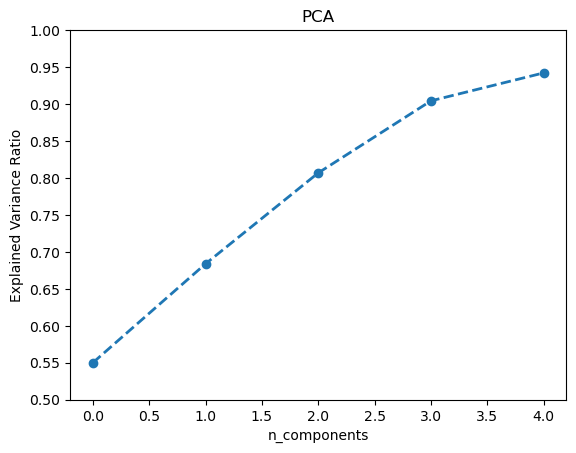

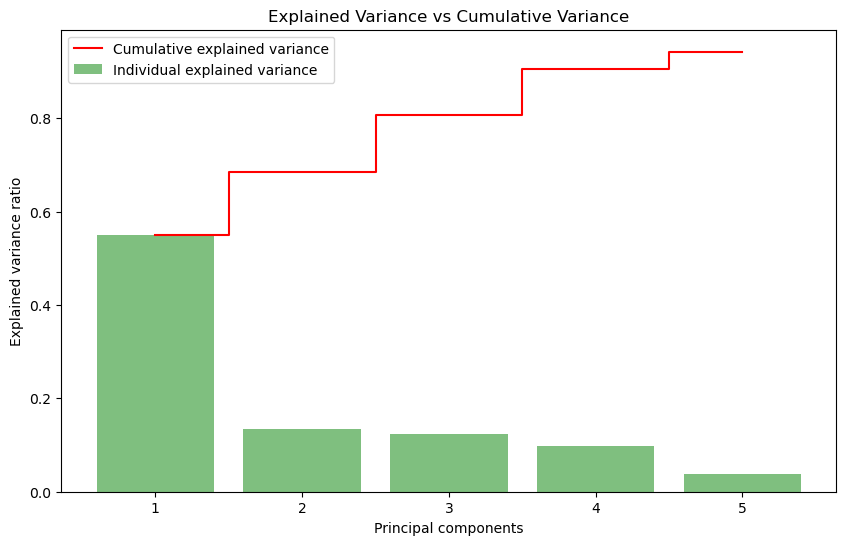

In [17]:
pca = PCA(n_components=5)
data_pca = pca.fit_transform(data_scaled_normalized)
pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_df['country'] = data['country']

explained_variance = pca.explained_variance_ratio_
print("Explained variance: ", explained_variance)

cumulative_variance = np.cumsum(explained_variance)
print("Cumulative variance: ", cumulative_variance)

# Scree Plot for PCA only
plt.plot(np.cumsum(explained_variance), linewidth=2, marker = 'o', linestyle = '--')
plt.title("PCA")
plt.xlabel('n_components')
plt.ylabel('Explained Variance Ratio')
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.show()

# Plot explained variance and cumulative variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance', color='g')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance', color='r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance vs Cumulative Variance')
plt.show()

From the above PCA plots of explained variance and cumulative variance, we can conclude that 5 components covers almost 95% of the data and we are going to use this in further analysis. 

## Data Modelling

### Elbow Method

#### The elbow method is a technique used in cluster analysis to determine the optimal number of clusters in a dataset

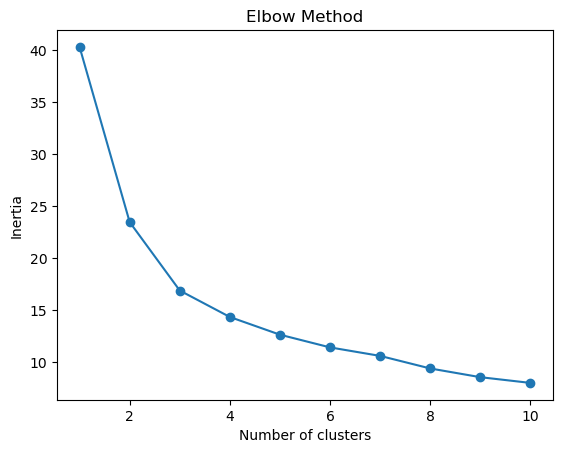

In [18]:
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=50, random_state=42)
    kmeans.fit(pca_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])
    inertia_list.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia_list, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

We can see that 3rd cluster is at the elbow point, which defines that 3 clusters will be the optimum number is our use case.

### Silhouette Score & Analysis

#### The Silhouette method is used to measure the quality of a clustering solution.

In [19]:
silhouette_scores = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='random', max_iter=50, random_state=42)
    kmeans.fit(pca_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']], kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    print(
        "For n_clusters={0}, the silhouette score is {1}".format(
            num_clusters, silhouette_avg
        )
    )

For n_clusters=2, the silhouette score is 0.40119072337167555
For n_clusters=3, the silhouette score is 0.36824988780742757
For n_clusters=4, the silhouette score is 0.3797677238451416
For n_clusters=5, the silhouette score is 0.26895208386154457
For n_clusters=6, the silhouette score is 0.23606504598234038
For n_clusters=7, the silhouette score is 0.24030581921036184
For n_clusters=8, the silhouette score is 0.2549166094462608


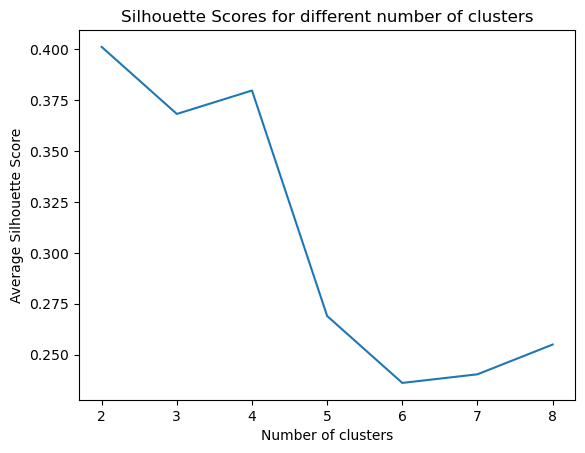

In [20]:
# Plotting the Silhoette score against each cluster
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Scores for different number of clusters')
plt.show()

### Generate Scatter Plot to decide on optimum of clusters

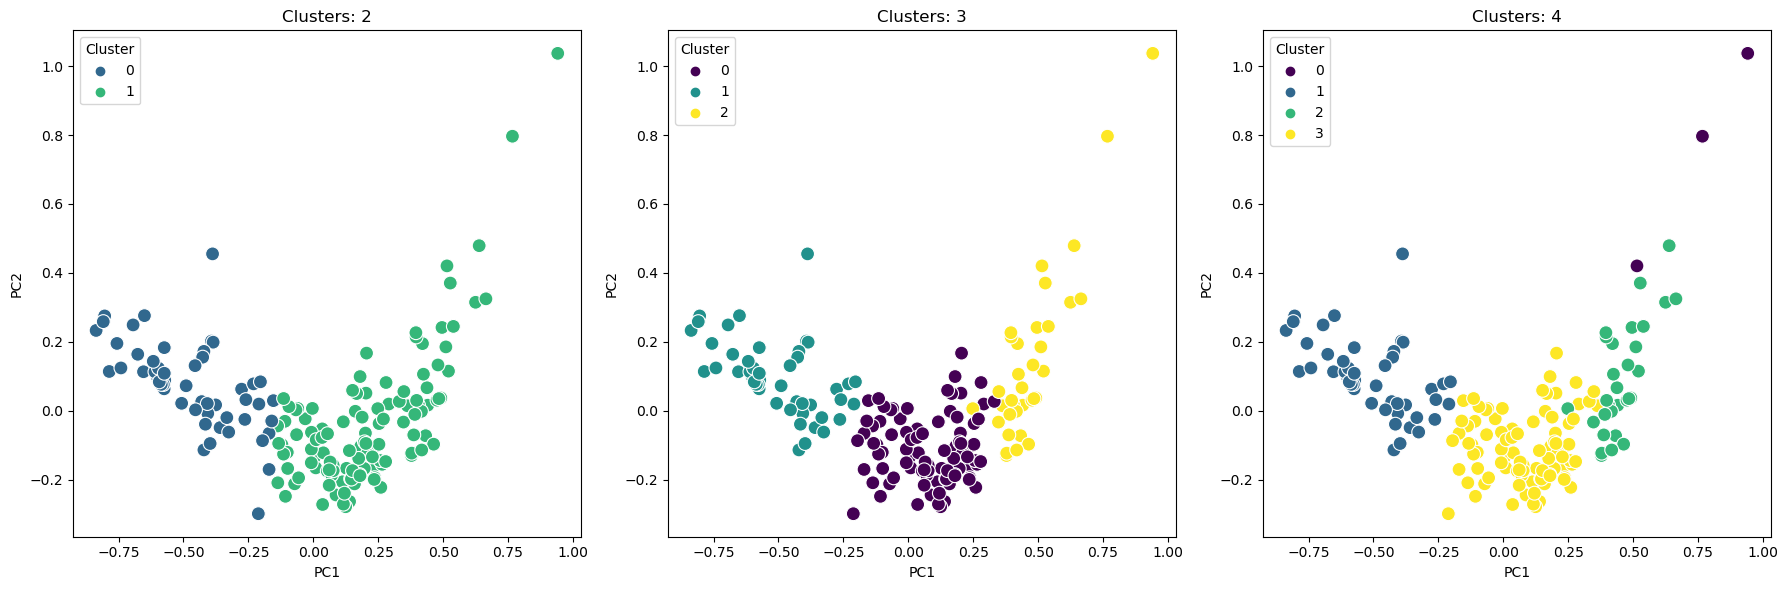

In [21]:
# Generate scatter plots for 2, 3, and 4 clusters
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, num_clusters in enumerate([2, 3, 4]):
    kmeans = KMeans(n_clusters=num_clusters, init='random', max_iter=50, random_state=42)
    kmeans.fit(pca_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])
    pca_df['Cluster'] = kmeans.labels_
    
    # Scatter plot
    sns.scatterplot(ax=axs[idx], x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
    axs[idx].set_title(f'Clusters: {num_clusters}')
    axs[idx].legend(title='Cluster')

plt.tight_layout()
plt.show()

### Fit the K-Means Model

In [22]:
kmeans = KMeans(n_clusters=3, init='random', max_iter=50, random_state=42)
model = kmeans.fit(pca_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])

pca_df['Class'] = kmeans.labels_

### Labelling

#### Label countries based on classes derived from K-Means Model

In [23]:
# For illustration, let's assume the following mapping based on your analysis
income_mapping = {1: "Low Income", 2: "High Income", 0: "Middle Income"}

# Map the cluster labels to income categories
pca_df['Income Category'] = pca_df['Class'].map(income_mapping)

# Merge with the original data to include other information
final_df = data.merge(pca_df[['country', 'Income Category']], on='country', how='left')

### Visual Map of the result

#### Nice world map is created using the choropleth map method, some of the coutries are mis coloured because they were missing in original dataset.

In [24]:
# Create the choropleth map
fig = px.choropleth(final_df,
                    locationmode='country names',
                    locations='country',
                    color='Income Category',
                    color_discrete_map={
                        'Rich countries': 'Green',
                        'Middle countries': 'LightBlue',
                        'Poor countries': 'Red'
                    })

# Update the layout of the map
fig.update_layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=2
    )
)

# Show the map
fig.show()

#### Above is the final result including labelling done.

#### Above result matches with our initial choropleth plot which I did with original dataset which infers that clustering has considered below conditions to create the clusters.

1. lower the child mortality
2. lower the imports
3. higher the income
4. lower the total fertility rate and
5. finally higher the GDP

Note: uncoloured countries on the map do not have data available in the original dataset.

#### Summary:

The most wealthy countries (High Income) are located in North America, Europe, Oceania and a few in Asia.
The (Low Income) countries lies in mainly across Africa and in Asia.
The average countries (Middle Income) are located in South America, Europe, Asia and North Africa